In [1]:
import importlib
from src import experiment
from src import plotting

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
def default_params():
    """
    Defines the default parameters for the experiment.

    Returns:
        dict: A dictionary containing the default parameter values.
    """
    params = {
        "time_steps": 4000,          # Total number of time steps in the experiment
        "task_dist": "DetPRL",        # Type of task distribution (e.g., Deterministic PRL)
        "init_reward_means": ([1, 0], [1, 0]),  # Initial reward means for each task
        "init_reward_probs": (0.8, 0.2),  # Initial probabilities for task rewards
        "task_reward_probs": None,   # Probabilities for rewards in tasks (optional)
        "n_tasks": 4,               # Number of tasks in the experiment
        "reward_prob": 1.0,          # Probability of receiving a reward
        "reward_var": 0.8,           # Variance of reward noise
        "n_trials": 10,              # Number of trials to average results
        "wI": [0.0, -0.2e-1, 0.5e-2],    # List of exploitative weight values for sensitivity sweeps
        "wE": 0.05,                   # Exploratory weight for policy updates
        "alpha": 1e-2,               # Learning rate for value updates
        "tau": 1e-2                  # Entropy regularization coefficient
    }
    return params


In [4]:
# Reload the modules after editing
importlib.reload(experiment)
importlib.reload(plotting)

# Re-import the functions if necessary
from src.experiment import sensitivity_sweep
from src.plotting import plot_results_2cols
# Load default parameters
params = default_params()

# # Run the sensitivity analysis, sweeping over wI
histories, environment = sensitivity_sweep(params, sweep_over="wI")

In [20]:
# Reload the modules after editing
importlib.reload(plotting)
# Re-import the functions if necessary
from src.plotting import plot_results_2cols2
# Plot the results
colormaps = [plt.cm.spring, plt.cm.summer, plt.cm.autumn, plt.cm.winter, plt.cm.cool]
n_colors = 1
colors2 = [colormaps[4](0.8)] + [colormaps[3](v) for v in np.linspace(0., 0.7, n_colors)[::-1]]
colors2 += [colormaps[1](v) for v in np.linspace(0., 0.6, n_colors)[::-1]]
colors_baseline = [colormaps[4](0.8), colormaps[4](0.8)]
# plot_results_2cols2(params, histories, environment, ["avg_reward"], colors, colors_baseline)

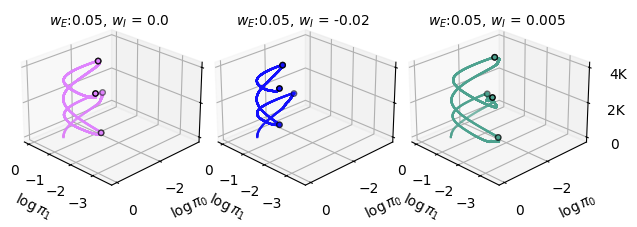

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
rows = 3
time_steps_per_task = 1000

importlib.reload(plotting)
# Re-import the functions if necessary
from src.plotting import dict_of, FONTSIZE

def plot_Q_3D(history, ax, total_time_steps, colors, alpha_values):
    # x = np.mean(history["avg_max_reward_1"], 0)
    # y = np.mean(history["avg_max_reward_0"], 0)
    x = np.mean(np.log(history["pi_0"]), 0)
    y = np.mean(np.log(history["pi_1"]), 0)

    x_all = [x]#np.log(history["pi_0"])  # shape: (n_runs, T)
    y_all = [y]#np.log(history["pi_1"])
    z = np.arange(total_time_steps)
    # n_runs = x_all.shape[0]
    # for run in range(1):
    #     x = x_all[run]
    #     y = y_all[run]
    for i in range(total_time_steps):
        if i % time_steps_per_task == time_steps_per_task - 1:
            ax.scatter(
                x[i:i+2], y[i:i+2], z[i:i+2],
                color=colors,
                alpha=alpha_values[i],
                s=15, marker='o', edgecolor='k',
            )
        else:
            ax.plot(
                x[i:i+2], y[i:i+2], z[i:i+2],
                color=colors,
                alpha=alpha_values[i],
                # lw=1,
            )

    ax.set_box_aspect([1, 1, 0.7])  # Adjust 3D plot proportions
    # Customize z-axis ticks and labels to use K notation
    tick_step = 2000
    z_ticks = np.arange(0, total_time_steps + 1, tick_step)
    z_ticklabels = [f"{int(tick/1000)}K" if tick != 0 else "0" for tick in z_ticks]
    ax.set_zticks(z_ticks)
    ax.set_zticklabels(z_ticklabels)

    ax.view_init(elev=25, azim=135)  # Customize view angle

# Plot setup
fig, axes = plt.subplots(
    1, rows, figsize=(2.5 * rows, 2.5),  # Scaled figure size
    sharex=True, sharey=True,
    subplot_kw={'projection': '3d'},
    # constrained_layout=True,
    constrained_layout=False,  # <- force disable this
    gridspec_kw={'wspace': 0.}  # Increase horizontal space between subplots
)

if rows == 1:
    axes = [axes]  # ensure axes is iterable

total_time_steps = n_tasks * time_steps_per_task
colors = [plt.get_cmap("rainbow")(i / (total_time_steps - 1)) for i in range(total_time_steps)]
alpha_values = np.linspace(0.1, 1., total_time_steps)

for row_idx in range(rows):
    ax = axes[row_idx]
    history = histories[row_idx]
    plot_Q_3D(history, ax, total_time_steps, colors2[row_idx], alpha_values)

    ax.set_xlabel(dict_of["log_pi_1"])
    ax.set_ylabel(dict_of["log_pi_0"])
    # ax.set_zlabel('timesteps')
    wI = params["wI"][row_idx]
    wE = params["wE"]
    colors2 = ['#df83ff',  '#1310ff', '#4da28f']
    ax.set_title(f"$w_E$:{wE}, $w_I$ = {wI}", fontsize=10, y=0.95)#, color=colors2[row_idx])
    ax.yaxis.set_tick_params(labelleft=True)

plt.show()